# 2. Score classic methods

In [3]:
from common import score_models, load_predictions, load_trues, draw_distribution_predictions, draw_bar_plot
from metrics import recall
import numpy as np

## Classic methods comparison

In [4]:
trues = load_trues("../reading_lists.csv", keys=["id_title"], acl_only=True)
preds = load_predictions([
    "classic_methods/preds/semantic_scholar/any",
    "classic_methods/preds/semantic_scholar/acl",
    "classic_methods/preds/bm25",
    "classic_methods/preds/specter2"
], keys=["id_title"])

preds_names = [
    "Semantic Scholar (Any)",
    "Semantic Scholar (ACL)",
    "BM25",
    "SPECTER2"
]

table = score_models(trues, preds, preds_names, split_by_years=False); table 
#print(table.to_latex(float_format="{:0.1f}".format))

recall                                     ndcg  \
                              A1        A2         A3      Mean        A1   
Semantic Scholar (Any)  4.478147  3.816047   6.673190  4.989128  2.213700   
Semantic Scholar (ACL)  8.649706  6.242661  10.476190  8.456186  5.719130   
BM25                    8.873668  8.489889  11.156773  9.506777  5.722704   
SPECTER2                5.787671  5.676778   8.245864  6.570104  3.064759   

                                                           mrr            \
                              A2        A3      Mean        A1        A2   
Semantic Scholar (Any)  2.376716  3.852367  2.814261  2.483752  3.451022   
Semantic Scholar (ACL)  4.527250  7.462571  5.902984  8.065528  6.669928   
BM25                    5.105861  6.581614  5.803393  8.765831  5.929288   
SPECTER2                3.397064  4.709815  3.723880  3.333865  4.578341   

                                             
                               A3      Mean  
Semantic Scholar (Any)   5.403053  3.779275  
Semantic Scholar (ACL)  11.021418  8.585625  
BM25                     9.199094  7.964738  
SPECTER2                 5.763281  4.558496

### Year repartition of predictions

Semantic Scholar (Any)
Average publication year of references is 2019, for oldest published reference in 1977 and more recent in of 2024.


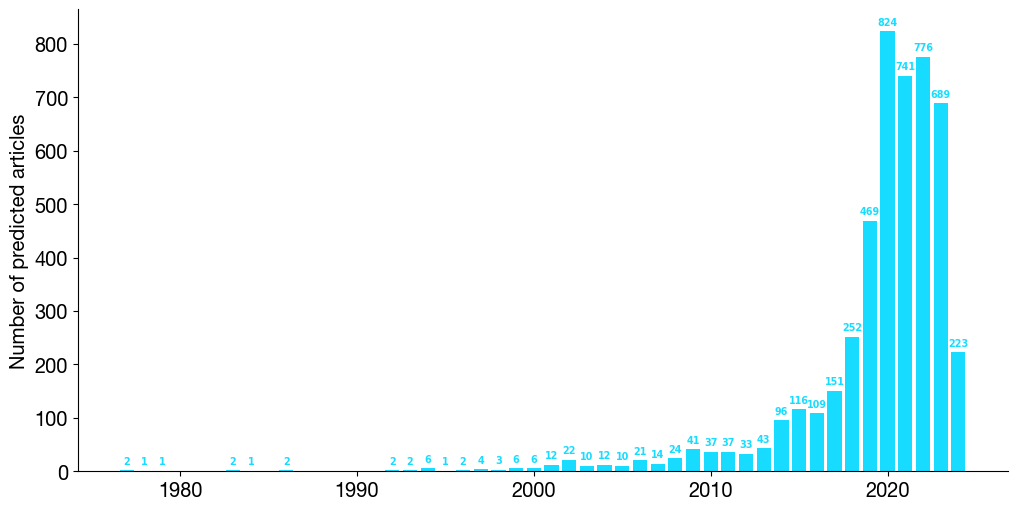

Semantic Scholar (ACL)
Average publication year of references is 2019, for oldest published reference in 1973 and more recent in of 2024.


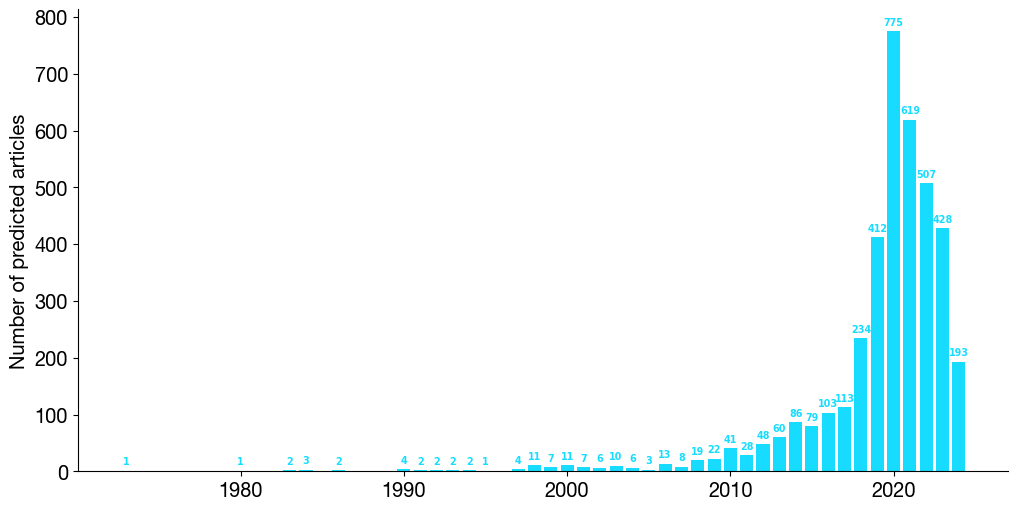

BM25
Average publication year of references is 2018, for oldest published reference in 1963 and more recent in of 2024.


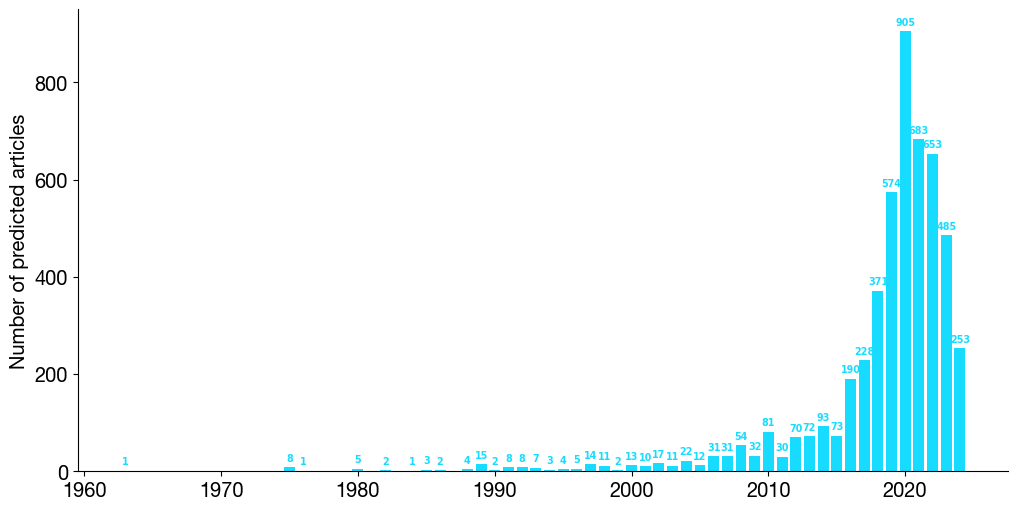

SPECTER2
Average publication year of references is 2011, for oldest published reference in 1961 and more recent in of 2024.


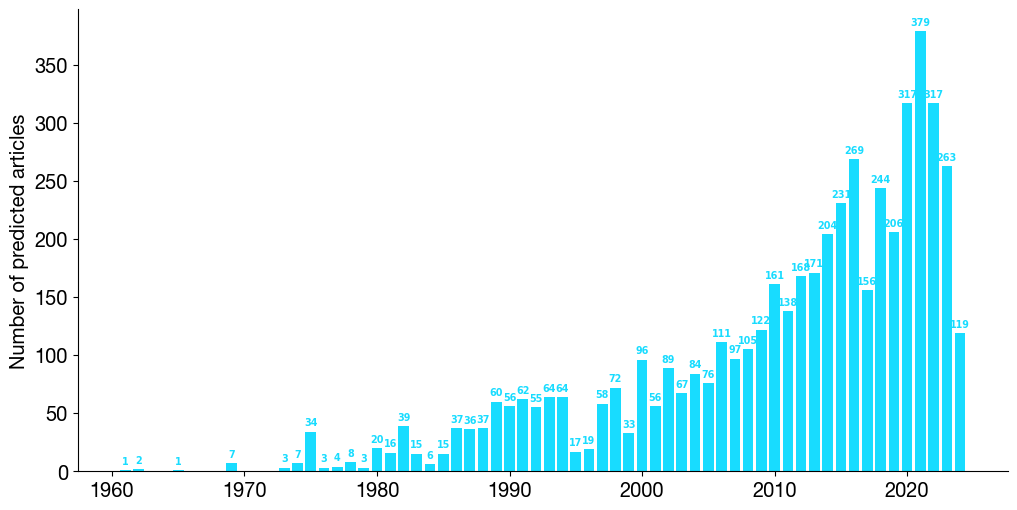

In [5]:
trues = load_trues("../reading_lists.csv", keys=["year"], acl_only=True)
models_preds = load_predictions([
    "classic_methods/preds/semantic_scholar/any",
    "classic_methods/preds/semantic_scholar/acl",
    "classic_methods/preds/bm25",
    "classic_methods/preds/specter2"
], keys=["year"])

models_names = [
    "Semantic Scholar (Any)",
    "Semantic Scholar (ACL)",
    "BM25",
    "SPECTER2"
]

for preds_annotators, model_name in zip(models_preds, models_names):
    years = []
    for preds_annotator in preds_annotators.values():
        for preds_years in preds_annotator.values():
            years = years + preds_years

    print(model_name)
    print(f"Average publication year of references is {round(np.mean(years))}, for oldest published reference in {np.min(years)} and more recent in of {np.max(years)}.")

    draw_distribution_predictions(years, ylabel="Number of predicted articles")

## Intersection of correct prediction (BM25 vs SPECTER2)

In [6]:
""" Compute intersection between correct prediction of two models """
def intersection_correct_predictions(trues:dict, preds1:dict, preds2:dict) -> float:
    matches = 0
    size = 0
    for k, trues_v in trues.items():
        if trues_v != []:
            
            match1 = set(dict.fromkeys(trues_v)) & set(dict.fromkeys(preds1[k]))
            match2 = set(dict.fromkeys(trues_v)) & set(dict.fromkeys(preds2[k]))
            matches += len(match1 & match2)
            size += 1

    return matches/size

In [7]:
trues = load_trues("../reading_lists.csv", keys=["id_title"], acl_only=True)
bm25_preds, specter2_preds = load_predictions([
    "classic_methods/preds/bm25",
    "classic_methods/preds/specter2"
], keys=["id_title"])

(intersection_correct_predictions(trues, bm25_preds["A1"], specter2_preds["A1"]) +\
intersection_correct_predictions(trues, bm25_preds["A2"], specter2_preds["A2"]) +\
intersection_correct_predictions(trues, bm25_preds["A3"], specter2_preds["A3"])) /3

0.1050228310502283

## Citations differences analysis

In [8]:
import numpy as np
import matplotlib.pyplot as plt

""" Compute and plot an histogram of % of citations"""
def draw_histogram_citations(hist:list, bins:list) -> None:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(len(hist)),hist,width=0.95, align="edge", color='#18dcff') 
    for container in ax.containers:# Add bar labels
        ax.bar_label(container,fmt='%.0f%%', padding=3, fontweight="bold", fontsize="large", color='#18dcff')
    ax.set_xticks([0.5+i for i,j in enumerate(hist)])
    ax.set_xticklabels([f"[{bins[i]}:{bins[i+1]}]" for i,j in enumerate(hist)])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Referenced papers", fontsize="x-large", fontfamily="Helvetica Neue")
    ax.set_ylabel("% of citations", fontsize="x-large", fontfamily="Helvetica Neue")
    ax.tick_params(axis='both', which='major', labelsize="x-large", labelfontfamily="Helvetica Neue", direction="out")
    plt.show()

""" Generate an histogram for citations values of predictions """
def histogram_citations(preds, annotators_ids:list=[1,2,3]) -> list:
    citations_list = []
    for annotator_id in annotators_ids:
        for pred_citations in preds[f"A{annotator_id}"].values():
            citations_list = citations_list + pred_citations
    hist, bins = np.histogram(citations_list, [0, 10, 50, 100, 1000, max(citations_list)])
    hist = [(count / len(citations_list)) * 100 for count in hist]
    return hist, bins

In [20]:
trues = load_trues("../reading_lists.csv", keys=["id_title"], acl_only=True)
preds = load_predictions([
    "classic_methods/preds/semantic_scholar/any",
    "classic_methods/preds/semantic_scholar/any_most_cited",
    "classic_methods/preds/semantic_scholar/acl",
    "classic_methods/preds/semantic_scholar/acl_most_cited"
], keys=["id_title"])

preds_names = [
    "Any",
    "Any - Most Cited",
    "ACL",
    "ACL - Most Cited"
]

table = score_models(trues, preds, preds_names, split_by_years=False); table 
#print(table.to_latex(float_format="{:0.1f}".format))

recall                                      ndcg  \
                         A1        A2         A3       Mean        A1   
Any                4.478147  3.816047   6.673190   4.989128  2.213700   
Any - Most Cited   5.587084  4.774951   8.228963   6.196999  3.772837   
ACL                8.649706  6.242661  10.476190   8.456186  5.719130   
ACL - Most Cited  10.613177  5.936073  14.602087  10.383779  7.287712   

                                                      mrr            \
                        A2        A3      Mean         A1        A2   
Any               2.376716  3.852367  2.814261   2.483752  3.451022   
Any - Most Cited  3.512437  6.310157  4.531810   6.082644  4.998713   
ACL               4.527250  7.462571  5.902984   8.065528  6.669928   
ACL - Most Cited  4.254474  9.869467  7.137218  10.981119  6.484611   

                                        
                         A3       Mean  
Any                5.403053   3.779275  
Any - Most Cited  10.480045   7.187134  
ACL               11.021418   8.585625  
ACL - Most Cited  13.297184  10.254305

<Axes: xlabel='Semantic Scholar', ylabel='recall'>

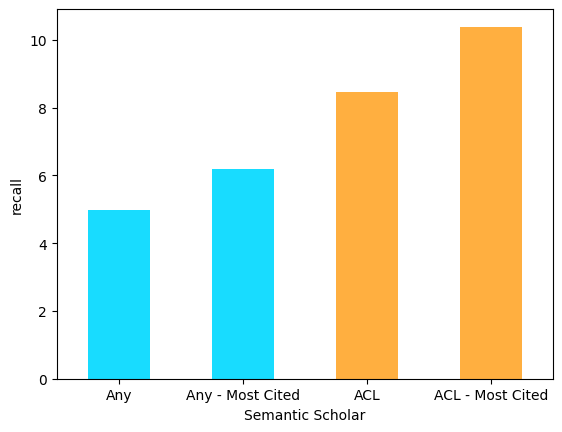

In [32]:
table["recall"]["Mean"].plot(kind="bar", xlabel="Semantic Scholar", ylabel="recall", rot=0, color=["#18dcff", "#18dcff", "#ffaf40","#ffaf40"])

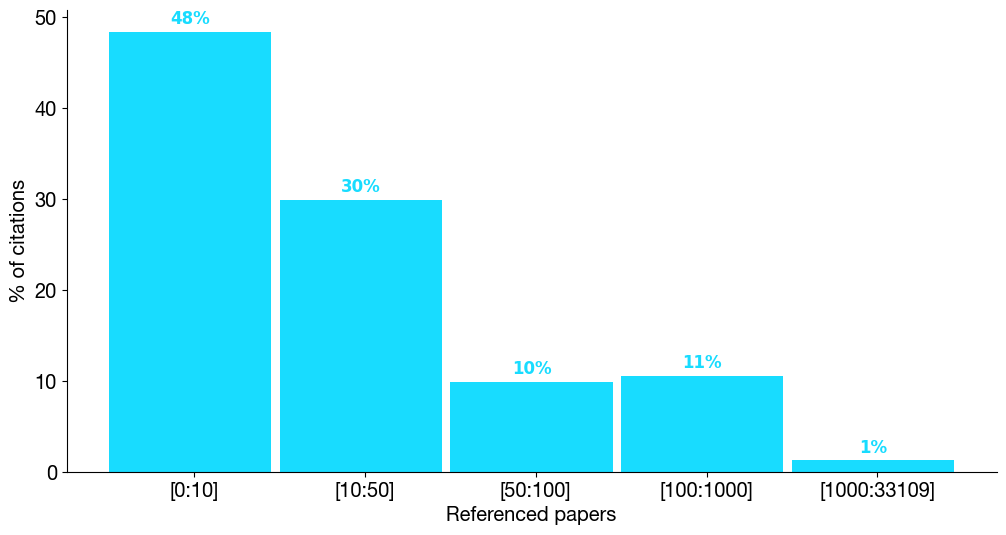

In [11]:
draw_histogram_citations(*histogram_citations(load_predictions(["classic_methods/preds/semantic_scholar/any"], keys=["citationCount"])[0]))

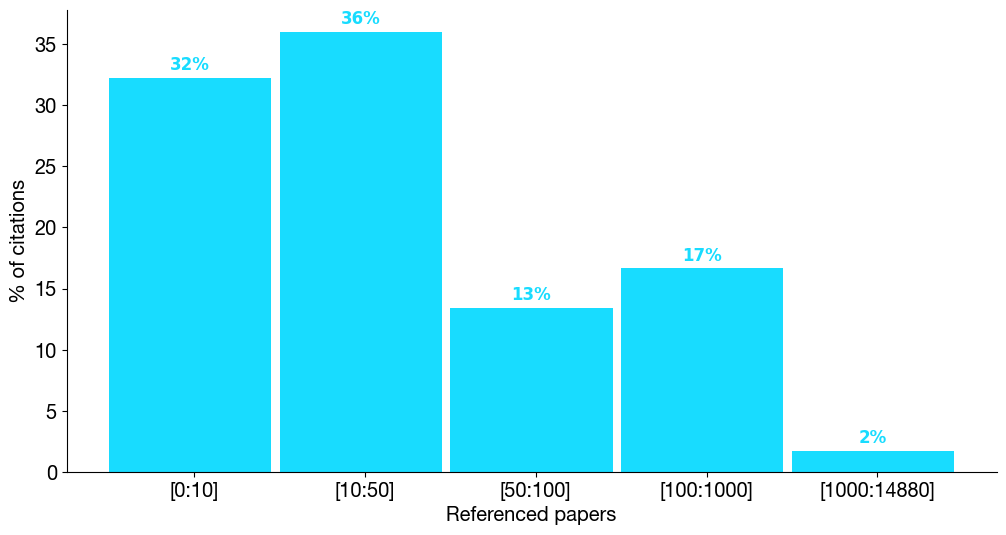

In [12]:
draw_histogram_citations(*histogram_citations(load_predictions(["classic_methods/preds/semantic_scholar/acl"], keys=["citationCount"])[0]))